# Welcome to the XPIA notebook for ATOC NWP!

October 8, 2021

Modified from a stack of other notebooks....

# 0.0 Import all the modules

In [1]:
import os
import csv
import numpy as np                  # For doing math
import matplotlib.pyplot as plt     # For plotting
import matplotlib.dates as mdates   # For formatting dates when plotting
import matplotlib.colors as colors  # For truncating colorbars
import matplotlib.units as munits
import matplotlib.style as style
import xarray as xr                 # For dealing with netCDF data
import pandas as pd                 # A quick way to deal with time stamps
import netCDF4 as nc                # Another way to deal with netCDF data
import glob
import metpy.calc as mpcalc
import datetime
import scipy.interpolate
import scipy.signal as sig
import scipy.stats as stats
import sys
import scipy.io as sio
from netCDF4 import Dataset
from scipy.optimize import curve_fit

from matplotlib import colors as mcolors
from metpy.plots import Hodograph, SkewT
from metpy.cbook import get_test_data
from metpy.units import units
from scipy.signal import savgol_filter
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpec
from numpy.random import seed
from numpy.random import rand
from datetime import datetime

import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings('ignore')
print('Done importing modules now')

Done importing modules now


This notebook assumes that your data is located in WRF_DIRECTORY. If you used a different directory structure, you will need to modify it.

In [2]:
WRF_DIRECTORY = '/projects/jiko1138/ATOC_NWP/ICA_07/'
PBL_DIR_1 = 'PBL99/'
PBL_DIR_2 = 'PBL04/'

### 1.0 Make the terrain map of the domain.

In [3]:
PBL_DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY + PBL_DIR_1 + "/wrfout_d01_2015-04-06_00:00:00")
PBL_DIR_1_d02 = xr.open_dataset(WRF_DIRECTORY + PBL_DIR_1 + "/wrfout_d02_2015-04-06_00:00:00")

print('Reading '+ PBL_DIR_1 + ' for mapping')

Reading PBL99/ for mapping


35.932957 43.90376
-111.662 -99.005066
No
38.66216 43.90376
-107.27617 -103.048706


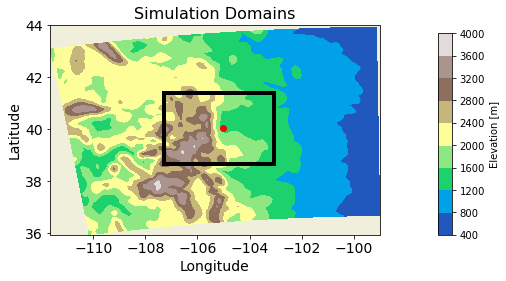

In [4]:
### Useful data and parameters for plotting

# Figure out the location we care about
desired_lon = -105.0038
desired_lat = 40.05

## Pull lat/lon from the dataset
lats1 = PBL_DIR_1_d01['XLAT'].isel(Time=0)    # Note: we must index-select Time=0 because plots expect 2D data (lat-lon)
longs1 = PBL_DIR_1_d01['XLONG'].isel(Time=0)
hgt1 = PBL_DIR_1_d01['HGT'].isel(Time=0)
lats2 = PBL_DIR_1_d02['XLAT'].isel(Time=0)
longs2 = PBL_DIR_1_d02['XLONG'].isel(Time=0)
hgt2 = PBL_DIR_1_d02['HGT'].isel(Time=0)

## Extract min/max values if you chose to bound the size of the map
min_lat1 = lats1.values.min()
max_lat1 = lats1.values.max()
min_lon1 = longs1.values.min()
max_lon1 = longs1.values.max()
MAP_BOUNDS1 = [min_lon1, max_lon1, min_lat1, max_lat1+0.1]

min_lat2 = lats2.values.min()
max_lat2 = lats2.values.max()
min_lon2 = longs2.values.min()
max_lon2 = longs2.values.max()
MAP_BOUNDS2 = [min_lon2, max_lon2, min_lat2, max_lat2]

print(min_lat1, max_lat1)
print(min_lon1, max_lon1)
print('No')
print(min_lat2, max_lat1)
print(min_lon2, max_lon2)

# Create figure and axes objects
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines
ax.set_extent(MAP_BOUNDS1)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)

# Draw bounding box for inner domain
ax.plot((min_lon2, min_lon2), (min_lat2, max_lat2), lw=4, color='k')
ax.plot((max_lon2, max_lon2), (min_lat2, max_lat2), lw=4, color='k')
ax.plot((min_lon2, max_lon2), (min_lat2, min_lat2), lw=4, color='k')
ax.plot((min_lon2, max_lon2), (max_lat2, max_lat2), lw=4, color='k')

c_levels = np.arange(0, 5000, 500)
im=ax.contourf(PBL_DIR_1_d01['XLONG'].values[0, :, :],
    PBL_DIR_1_d01['XLAT'].values[0, :, :],
    PBL_DIR_1_d01['HGT'].values[0, :, :], #c_levels,
    cmap=plt.cm.terrain)

#### Projection is messed up here - figure out how to fix this!

# Add important info to the plot
ax.set_title("Simulation Domains", fontsize=16)
ax.xaxis.set_visible(True)    # Set xaxis visible because cartopy hides it by default
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)

ax.scatter([desired_lon], [desired_lat], color='r') # Dot for location of BAO

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Elevation [m]")

# Adjust figure height so the xlabel isn't cut off when saved
plt.gcf().subplots_adjust(bottom=0.15)

plt.savefig("domain.png")
plt.savefig("domain.pdf")

plt.show()

In [5]:
def destagger(var, stagger_dim):
    '''
    From wrf-python https://github.com/NCAR/wrf-python/blob/b40d1d6e2d4aea3dd2dda03aae18e268b1e9291e/src/wrf/destag.py 
    '''
    var_shape = var.shape
    num_dims = var.ndim
    stagger_dim_size = var_shape[stagger_dim]

    full_slice = slice(None)
    slice1 = slice(0, stagger_dim_size - 1, 1)
    slice2 = slice(1, stagger_dim_size, 1)

    dim_ranges_1 = [full_slice] * num_dims
    dim_ranges_2 = [full_slice] * num_dims

    dim_ranges_1[stagger_dim] = slice1
    dim_ranges_2[stagger_dim] = slice2

    result = .5*(var[tuple(dim_ranges_1)] + var[tuple(dim_ranges_2)])

    return result

Now read in all the files and the appropriate data from each of the files

In [6]:
# Get the list of all the wrfout files in the directory

PBL_DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY + PBL_DIR_1 + "/wrfout_d01_2015-04-06_00:00:00")
filenames = sorted([f for f in glob.glob(WRF_DIRECTORY + PBL_DIR_1 + "/wrfout_d02_*")])
# print(filenames)

# loop through the files and read in the u, v, height, and time 
P = []
PB = []

GRDFLX = []
Times = []
xtime =[]
height =[]
u =[]
v =[]

for f in filenames :
    print('Reading ',f)
    ds = nc.Dataset(f)
    
#     height = ( PH + PHB ) / 9.81
#     height.append(ds['height'][:])

# Here we are using height above the ground
    ind_max_s=[39,49]
    height.append(( ds['PH'][:]+ds['PHB'][:])/9.81 - ds['HGT'][:])
    
    u.append(ds['U'][:])
    v.append(ds['V'][:])
    Times.append(ds['Times'][:])
    xtime.append(ds['XTIME'][:])
    GRDFLX.append(ds['GRDFLX'][:])
    P.append(ds['P'][:])
    PB.append(ds['PB'][:])
    

u = np.squeeze(u)
v = np.squeeze(v)
Times = np.squeeze(Times)
xtime = np.squeeze(xtime)

P  = np.squeeze(P)
PB  = np.squeeze(PB)
totalp = P

height = np.squeeze(height)
print(height[0,:,ind_max_s[0],ind_max_s[1]])

print('Height:',np.shape(height))
# print('U:',np.shape(u))
# print('V:',np.shape(v))
print('Times:',np.shape(Times))
print('xtime:',np.shape(xtime))

# unstagger velocities after reading everything in

u_destag = destagger(u, 3)
v_destag = destagger(v, 2)
height_destag = destagger(height, 1)

# print('U:',np.shape(u_destag))
# print('V:',np.shape(v_destag))

u = u_destag # could probably have done this in one line with the destagger call
v = v_destag
height = height_destag

print('U:', np.shape(u))
print('V:', np.shape(v))
print('Height:', np.shape(height))
print('Wind Speed:', np.shape(totalp))

ws = (u**2 + v**2)**0.5

Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_00:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_01:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_02:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_03:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_04:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_05:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_06:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_07:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_08:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_09:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_10:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL99/wrfout_d02_2015-04-06_11:00:00
Reading  /projects/jiko1138/

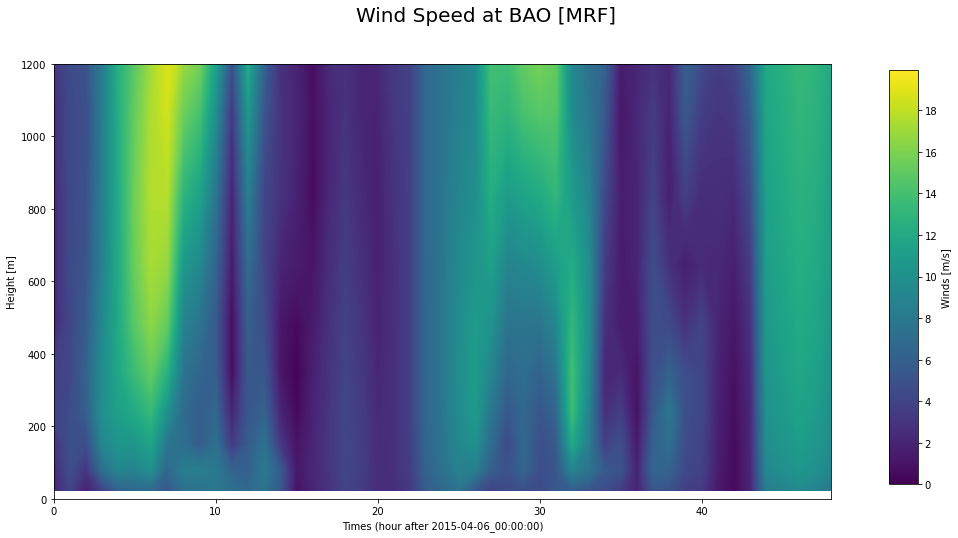

In [7]:
km_lon = 100 # at 85 km at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude at 25.89 N-- should really use a projection here
km_lat = 111 # 111 km per degree of latitude (edited) 
dist = np.sqrt(np.square(abs(km_lon*(longs2[:,:] - desired_lon))) 
             + np.square(abs(km_lat*(lats2[:,:]  - desired_lat))))

# ind_max_s = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

# Not working....
ind_max_s=[39,49]   # Just trust me on this for now...this is the location of the tower

# Now create a contour plot of time on the x-axis and height on the y-axis

fig, ax = plt.subplots(1,1,figsize=(16,8), sharex=True, sharey=True)
c_levels = np.arange(0, 20, 0.05)
                       
time_axis = xtime

winds = ws[:,:,ind_max_s[0],ind_max_s[1]]
# print(np.min(winds),np.max(winds))
windst = np.transpose(winds)
# print(np.shape(windst))

im = ax.contourf(
    time_axis/60,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    windst, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Wind Speed at BAO [MRF]", fontsize=20)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")")
ax.set_ylabel("Height [m]")
ax.set_ylim(0,1200)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.72])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Winds [m/s]")

plt.savefig("MRF_nonlocal.png")
plt.show()

time_axis_MRF=time_axis
height_MRF=height
GRDFLX_MRF= GRDFLX
totalp_MRF=totalp

(32, 49)
(32, 49)


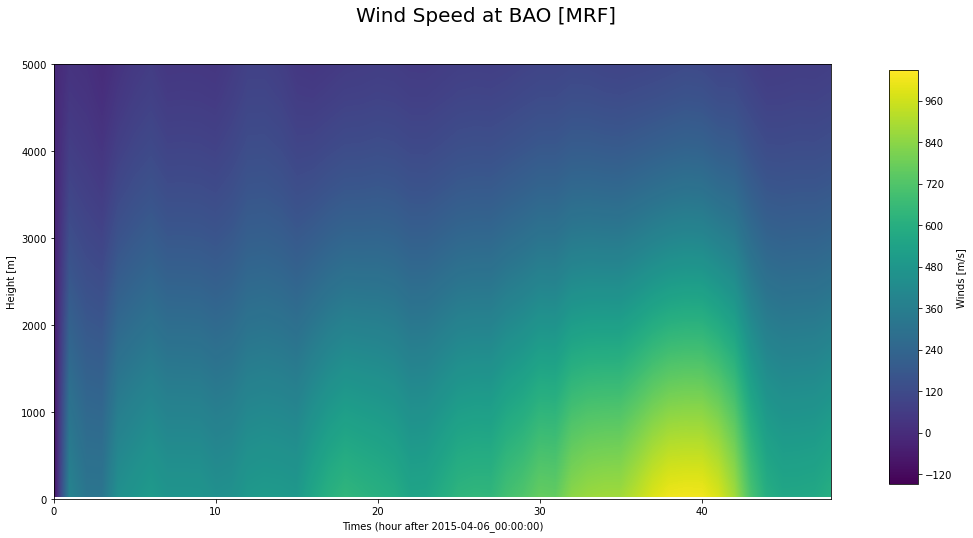

In [8]:
km_lon = 100 # at 85 km at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude at 25.89 N-- should really use a projection here
km_lat = 111 # 111 km per degree of latitude (edited) 
dist = np.sqrt(np.square(abs(km_lon*(longs2[:,:] - desired_lon))) 
             + np.square(abs(km_lat*(lats2[:,:]  - desired_lat))))

# ind_max_s = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

# Not working....
ind_max_s=[39,49]   # Just trust me on this for now...this is the location of the tower

# Now create a contour plot of time on the x-axis and height on the y-axis

fig, ax = plt.subplots(1,1,figsize=(16,8), sharex=True, sharey=True)
c_levels = np.arange(-150, 1050, 1)
                       
time_axis = xtime

data_MRF = totalp_MRF[:,:,ind_max_s[0],ind_max_s[1]]
MRF_data = np.transpose(data_MRF)

print(np.shape(MRF_data))
print(np.shape(windst))

im = ax.contourf(
    time_axis/60,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    MRF_data, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Wind Speed at BAO [MRF]", fontsize=20)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")")
ax.set_ylabel("Height [m]")
ax.set_ylim(0,5000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.72])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Winds [m/s]")

plt.savefig("MRF_P.png")
plt.show()

In [9]:
# Get the list of all the wrfout files in the directory

PBL_DIR_1_d01 = xr.open_dataset(WRF_DIRECTORY + PBL_DIR_2 + "/wrfout_d01_2015-04-06_00:00:00")
filenames = sorted([f for f in glob.glob(WRF_DIRECTORY + PBL_DIR_2 + "/wrfout_d02_*")])
# print(filenames)

# loop through the files and read in the u, v, height, and time 
P = []
PB = []

GRDFLX = []
Times = []
xtime =[]
height =[]
u =[]
v =[]

for f in filenames :
    print('Reading ',f)
    ds = nc.Dataset(f)
    
#     height = ( PH + PHB ) / 9.81
#     height.append(ds['height'][:])

# Here we are using height above the ground
    height.append(( ds['PH'][:]+ds['PHB'][:])/9.81 - ds['HGT'][:])
    
    u.append(ds['U'][:])
    v.append(ds['V'][:])
    Times.append(ds['Times'][:])
    xtime.append(ds['XTIME'][:])
    GRDFLX.append(ds['GRDFLX'][:])
    P.append(ds['P'][:])
    PB.append(ds['PB'][:])
    
height = np.squeeze(height)
u = np.squeeze(u)
v = np.squeeze(v)
Times = np.squeeze(Times)
xtime = np.squeeze(xtime)

P  = np.squeeze(P)
PB  = np.squeeze(PB)
totalp = P


print('Height:',np.shape(height))
# print('U:',np.shape(u))
# print('V:',np.shape(v))
print('Times:',np.shape(Times))
print('xtime:',np.shape(xtime))

# unstagger velocities after reading everything in

u_destag = destagger(u, 3)
v_destag = destagger(v, 2)
height_destag = destagger(height, 1)

# print('U:',np.shape(u_destag))
# print('V:',np.shape(v_destag))

u = u_destag # could probably have done this in one line with the destagger call
v = v_destag
height = height_destag

print('U:', np.shape(u))
print('V:', np.shape(v))
print('Height:', np.shape(height))

ws = (u**2 + v**2)**0.5

print('Wind Speed:', np.shape(ws))

Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_00:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_01:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_02:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_03:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_04:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_05:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_06:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_07:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_08:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_09:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_10:00:00
Reading  /projects/jiko1138/ATOC_NWP/ICA_07/PBL04/wrfout_d02_2015-04-06_11:00:00
Reading  /projects/jiko1138/

[[ 2.6486223  4.7666063  3.4430141 ...  4.1339555  3.626236   5.1528764]
 [ 2.6461434  6.849809   6.195201  ...  4.350134   3.8450847  5.4591875]
 [ 1.7837116  7.173095   6.641165  ...  4.3922358  3.8933153  5.6036773]
 ...
 [33.627537  33.53803   33.488983  ... 19.06912   16.068575  15.042973 ]
 [29.60354   30.278704  31.404903  ...  9.963575  11.514966  14.234076 ]
 [25.23902   26.277706  29.061937  ...  4.4786153  6.726587   7.5264316]]
[   24.5531      80.278076   150.81122    239.55945    350.05127
   485.79034    650.42883    847.18384   1078.3444    1345.105
  1647.3505    1983.6807    2351.651     2749.1182    3177.8044
  3643.2446    4152.2827    4712.8276    5334.219     6002.9624
  6692.739     7396.256     8112.414     8827.066     9526.26
 10210.168    10885.262    11560.173    12239.838    12925.801
 13617.371    14312.107   ]


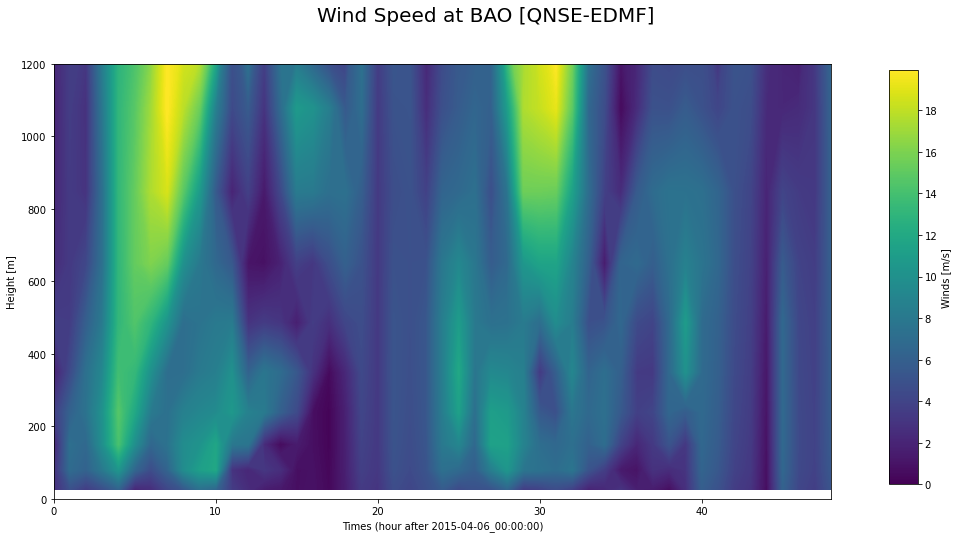

In [15]:
km_lon = 100 # at 85 km at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude at 25.89 N-- should really use a projection here
km_lat = 111 # 111 km per degree of latitude (edited) 
dist = np.sqrt(np.square(abs(km_lon*(longs2[:,:] - desired_lon))) 
             + np.square(abs(km_lat*(lats2[:,:]  - desired_lat))))

# ind_max_s = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

# Not working....
ind_max_s=[39,49]   # Just trust me on this for now...this is the location of the tower

# Now create a contour plot of time on the x-axis and height on the y-axis

fig, ax = plt.subplots(1,1,figsize=(16,8), sharex=True, sharey=True)
c_levels = np.arange(0, 20, 0.05)
                       
time_axis = xtime

winds = ws[:,:,ind_max_s[0],ind_max_s[1]]
# print(np.min(winds),np.max(winds))
windst = np.transpose(winds)
# print(np.shape(windst))

im = ax.contourf(
    time_axis/60,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    windst, c_levels,
    cmap=plt.cm.viridis)

print(windst)
print(height[0,:,ind_max_s[0],ind_max_s[1]])

plt.suptitle("Wind Speed at BAO [QNSE-EDMF]", fontsize=20)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")")
ax.set_ylabel("Height [m]")
ax.set_ylim(0,1200)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.72])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Winds [m/s]")

plt.savefig("QNSE_local.png")
plt.show()

time_axis_QNSE=time_axis
height_QNSE=height
GRDFLX_QNSE=GRDFLX
totalp_QNSE=totalp

(32, 49)
(32, 49)


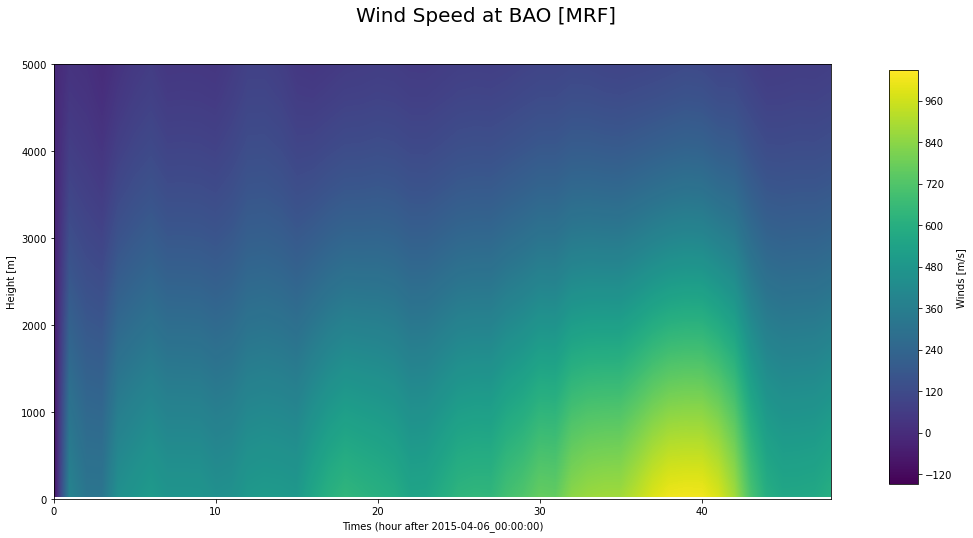

In [231]:
km_lon = 100 # at 85 km at 25.89 N, 100 km at 40 deg N, 85 km per degree of longitude at 25.89 N-- should really use a projection here
km_lat = 111 # 111 km per degree of latitude (edited) 
dist = np.sqrt(np.square(abs(km_lon*(longs2[:,:] - desired_lon))) 
             + np.square(abs(km_lat*(lats2[:,:]  - desired_lat))))

# ind_max_s = np.unravel_index(np.argmin(dist, axis=None), dist.shape)

# Not working....
ind_max_s=[39,49]   # Just trust me on this for now...this is the location of the tower

# Now create a contour plot of time on the x-axis and height on the y-axis

fig, ax = plt.subplots(1,1,figsize=(16,8), sharex=True, sharey=True)
c_levels = np.arange(-150, 1050, 1)
                       
time_axis = xtime

data_QNSE = totalp_QNSE[:,:,ind_max_s[0],ind_max_s[1]]
QNSE_data = np.transpose(data_QNSE)

print(np.shape(QNSE_data))
print(np.shape(windst))

im = ax.contourf(
    time_axis/60,
    height[0,:,ind_max_s[0],ind_max_s[1]],
    MRF_data, c_levels,
    cmap=plt.cm.viridis)

plt.suptitle("Wind Speed at BAO [MRF]", fontsize=20)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")")
ax.set_ylabel("Height [m]")
ax.set_ylim(0,5000)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.72])
                                                                 
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Winds [m/s]")

plt.savefig("QNSE_P.png")
plt.show()

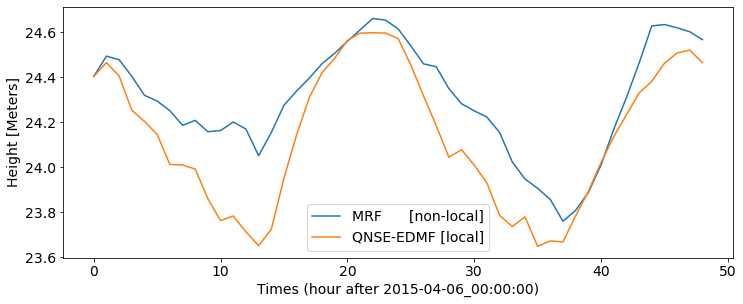

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(time_axis_MRF/60, height_MRF[:, 0, 39, 49], label='MRF      [non-local]')
ax.plot(time_axis_QNSE/60, height_QNSE[:, 0, 39, 49], label='QNSE-EDMF [local]')
ax.legend(fontsize=14)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")", fontsize=14)
ax.set_ylabel("Height [Meters]", fontsize=14)
ax.tick_params(labelsize=14)

# Format the x-axis labels nicely
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig("timeseries_height.png")

plt.show()

(49, 81, 99)


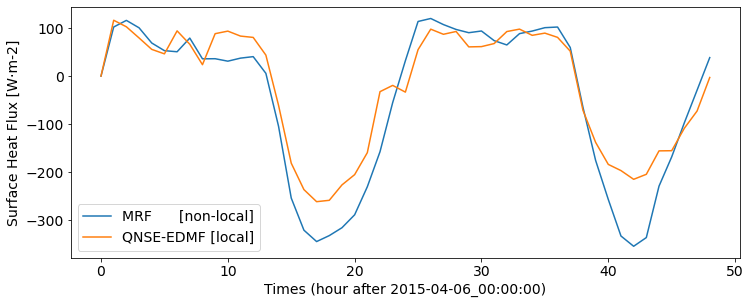

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

GRDFLX_MRF=np.squeeze(GRDFLX_MRF)
GRDFLX_QNSE=np.squeeze(GRDFLX_QNSE)

print(np.shape(GRDFLX_MRF))

ax.plot(time_axis_MRF/60, GRDFLX_MRF[:, 39, 49], label='MRF      [non-local]')
ax.plot(time_axis_QNSE/60, GRDFLX_QNSE[:, 39, 49], label='QNSE-EDMF [local]')
ax.legend(fontsize=14)

ax.set_xlabel("Times (hour after " + ds.SIMULATION_START_DATE + ")", fontsize=14)
ax.set_ylabel("Surface Heat Flux [W·m-2]", fontsize=14)
ax.tick_params(labelsize=14)

# Format the x-axis labels nicely
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig("timeseries_GRDFLX.png")

plt.show()

In [145]:
print(PBL_DIR_1_d01)

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 79, west_east: 99, bottom_top: 32, bottom_top_stag: 33, soil_layers_stag: 4, west_east_stag: 100, south_north_stag: 80, seed_dim_stag: 2)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/188)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float3